# QCNN: Quantum Convolutional Neural Network

In [18]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  # Avoids OpenMP library conflict errors

### Importing Libraries

In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.distributions import Categorical
from torchvision.transforms import Resize
import torch.optim as optim
from torch.optim import Optimizer  # Custom optimizer class later

import matplotlib.image as img
import scipy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import time
import csv
import pandas as pd

### Global path to store results

In [ ]:
# Directory to save trained models
path = './full_qcnn/'

### Hyperparameters

In [ ]:
n_epochs = 2  
batch_size_train = 64
batch_size_test = 1000  
learning_rate = 0.01 
momentum = 0
log_interval = 10  

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

### Import Data

In [67]:
# Define transformations for MNIST dataset
transform_mnist = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset (train and test)
trainset_mnist = torchvision.datasets.MNIST(root='./data-mnist', train=True, download=False, transform=transform_mnist)
trainloader_mnist = torch.utils.data.DataLoader(trainset_mnist, batch_size=batch_size_train, shuffle=True, num_workers=2)

testset_mnist = torchvision.datasets.MNIST(root='./data-mnist', train=False, download=False, transform=transform_mnist)
testloader_mnist = torch.utils.data.DataLoader(testset_mnist, batch_size=batch_size_test, shuffle=False, num_workers=2)

# Define MNIST class labels
classes_mnist = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

### Train and Test function


In [68]:
# Training function
def train(epoch, train_loader, network, name, path, optimizer):
    network.train()  # Set network to training mode
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()  # Reset gradients
        output = network(data)  # Forward pass
        loss = F.nll_loss(output, target)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters
        
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}', end='\r')
            train_losses.append(loss.item())
            train_counter.append((batch_idx * batch_size_train) + ((epoch - 1) * len(train_loader.dataset)))
            
            # Save model and optimizer state
            torch.save(network.state_dict(), path + f'model_{name}.pth')
            torch.save(optimizer.state_dict(), path + f'optimizer_{name}.pth')
            
            # Save training loss curve to CSV
            df = pd.DataFrame({'losses': train_losses, 'counter': train_counter})
            df.to_csv(path + f'traincurve_{name}.csv')

def train_from_middle(epoch, train_loader, network, name, path, optimizer, number_current_logs):
    '''Train from a pretrained network!''' 
    # Calculate the total expected logs for the training process
    total_expected_logs = np.ceil(n_epochs * 60000 / (batch_size_train * log_interval))
    
    # Determine the batch index to resume training from
    current_batch_idx = number_current_logs * log_interval - 94 * (epoch - 1) * log_interval  # Removing batch_idx from previous epochs (94 logs per epoch)
    print('current_batch_idx:', current_batch_idx)
    
    network.train()
    
    # Start training from the specified batch index
    for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx < current_batch_idx:
            continue  # Skip batches until reaching the current_batch_idx
        else:
            optimizer.zero_grad()  # Reset gradients
            output = network(data)  # Forward pass
            loss = F.nll_loss(output, target)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters
            
            # Logging the training process at intervals
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()), end='\r')
                
                # Store loss and training progress
                train_losses.append(loss.item())
                train_counter.append((batch_idx * batch_size_train) + ((epoch - 1) * len(train_loader.dataset)))
                
                # Save the model and optimizer state
                torch.save(network.state_dict(), path + 'model_' + name + '.pth')
                torch.save(optimizer.state_dict(), path + 'optimizer_' + name + '.pth')
                
                # Save training progress to a CSV file
                df = pd.DataFrame({'losses': train_losses, 'counter': train_counter})
                df.to_csv(path + 'traincurve_' + name + '.csv')

In [69]:
# Testing function
def test(test_loader, network):
    network.eval()  # Set network to evaluation mode
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]  # Get predicted class
            correct += pred.eq(target.data.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.2f}%)\n')
    return test_loss

### Stochastic Gradient Descent implementation

In [70]:
class Quantum_SGD(Optimizer): 
    def __init__(self, params, lr=0, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False, noise=0): 
        """
        Custom implementation of Stochastic Gradient Descent (SGD) with added quantum noise.
        
        Parameters:
        - params: model parameters to optimize
        - lr: learning rate
        - momentum: momentum factor for acceleration
        - dampening: dampening term for momentum
        - weight_decay: L2 regularization term
        - nesterov: whether to use Nesterov accelerated gradient
        - noise: standard deviation of Gaussian noise added to gradients
        """
        
        # Validate input parameters
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        if noise < 0.0:
            raise ValueError("Invalid noise value: {}".format(noise))

        # Store parameters as defaults
        defaults = dict(lr=lr, momentum=momentum, dampening=dampening, weight_decay=weight_decay, 
                        nesterov=nesterov, noise=noise) 
        
        # Check validity of Nesterov acceleration
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        
        super(Quantum_SGD, self).__init__(params, defaults)
    
    def __setstate__(self, state):
        """Restore state of optimizer."""
        super(Quantum_SGD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)
    
    def step(self, closure=None):
        """
        Performs a single optimization step, applying quantum noise to gradients.
        """
        loss = None
        if closure is not None:
            loss = closure()
        
        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']
            noise = group['noise']  # Added quantum noise parameter
            
            for p in group['params']:
                if p.grad is None:
                    continue
                
                d_p = p.grad.data  # Gradient of parameter p
                
                # Apply weight decay if specified (L2 regularization)
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                
                # Apply momentum if specified
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(1 - dampening, d_p)
                    if nesterov:
                        d_p = d_p.add(momentum, buf)
                    else:
                        d_p = buf
                
                # Apply quantum noise
                # Noise tensor is Gaussian distributed with mean 0 and std = noise
                noise_tensor = torch.Tensor(p.data.new(p.size()).normal_(0, noise))
                
                # Compute the L2 norm of the gradient
                norml2_dp = torch.norm(d_p)
                
                # Add noise to the gradient, scaled by its L2 norm
                noisy_grad = torch.add(d_p, norml2_dp * noise_tensor)
                
                # Update parameters using noisy gradient
                p.data.add_(-group['lr'], noisy_grad)               
        
        return loss

In [71]:
class Classical_SGD(Optimizer):
    """
    Implements a standard Stochastic Gradient Descent (SGD) optimizer.
    Unlike Quantum_SGD, this version does not introduce quantum noise.
    """
    def __init__(self, params, lr=0, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False):
        # Validate hyperparameter values
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        
        # Define optimizer defaults
        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov)
        
        # Ensure Nesterov momentum is used correctly
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        
        # Call the parent class constructor
        super(Classical_SGD, self).__init__(params, defaults)
    
    def __setstate__(self, state):
        """Restores the optimizer state from a saved checkpoint."""
        super(Classical_SGD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)
    
    def step(self, closure=None):
        """
        Performs a single optimization step.
        Unlike Quantum_SGD, this implementation does not introduce quantum noise.
        """
        loss = None
        if closure is not None:
            loss = closure()
        
        # Iterate over parameter groups
        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']
            
            # Iterate over each parameter in the group
            for p in group['params']:
                if p.grad is None:
                    continue  # Skip parameters with no gradients
                
                d_p = p.grad.data  # Get gradient data
                
                # Apply weight decay (L2 regularization)
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                
                # Apply momentum if enabled
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(1 - dampening, d_p)
                    
                    # Apply Nesterov momentum if enabled
                    if nesterov:
                        d_p = d_p.add(momentum, buf)
                    else:
                        d_p = buf
                
                # Update parameter values using gradient descent
                p.data.add_(-group['lr'], d_p)               
        
        return loss


### Classic CNN

In [72]:
# Define CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_size=7)
        self.conv2 = nn.Conv2d(5, 10, kernel_size=7)
        self.fc1 = nn.Linear(2560, 300) 
        self.fc2 = nn.Linear(300, 50)
        self.fc3 = nn.Linear(50, 10)

    def activation_function_ReLu(self, input_tensor):
        # Implements the ReLU activation function manually (clipping values below 0)
        output_tensor = torch.clamp(input_tensor, min=0)
        return output_tensor

    def forward(self, x):
        # Forward pass through the first convolutional layer
        x = self.conv1(x)
        x = self.activation_function_ReLu(x)
        x = self.conv2(x)
        x = self.activation_function_ReLu(x)

        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        
        return x

In [73]:
# Instantiate model and optimizer
network = CNN()
optimizer = Classical_SGD(network.parameters(), lr=learning_rate, momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(trainloader_mnist.dataset) for i in range(n_epochs + 1)]

# name
name = "CNN"

# Run several train on the whole dataset, and test each time at the end
for epoch in range(1, n_epochs + 1):
    print("Epoch #",epoch)
    train(epoch, trainloader_mnist, network, name, path, optimizer)
torch.save(network.state_dict(), path+'model_'+name+'.pth')

Epoch # 1
Epoch # 2ch: 1 [59520/60000 (99%)]	Loss: 0.243887


test

Test set: Avg. loss: 0.1280, Accuracy: 9591/10000 (95.91%)


train

Test set: Avg. loss: 0.1286, Accuracy: 57645/60000 (96.08%)



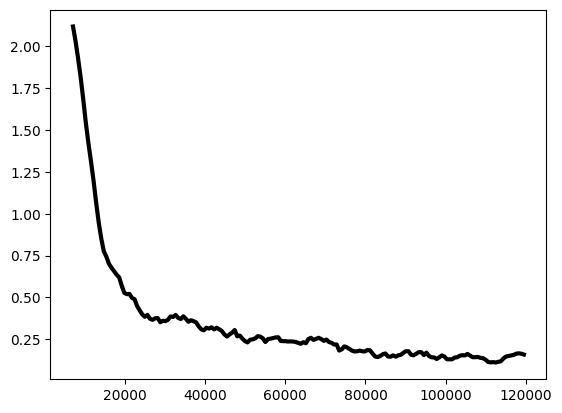

In [74]:
# Testing
print('test')
test(testloader_mnist, network)
print('\ntrain')
test(trainloader_mnist, network)

window=12

df_train = pd.DataFrame()
df_train[name] = pd.read_csv(path+'traincurve_'+name+'.csv',index_col='counter')['losses']
df_train['rollmean_'+name] = df_train[name].rolling(window=window).mean()
plt.plot(df_train['rollmean_CNN'], color='black', label='CNN', linewidth=3)
plt.show()

### Quantum CNN

In [75]:
# Define the Quantum Convolutional Neural Network (QCNN)
class QCNN(nn.Module):
    def __init__(self, Cap, epsilon, ratio):
        super(QCNN, self).__init__()
        self.Cap = Cap
        self.epsilon = epsilon
        self.ratio = ratio
        self.conv1 = nn.Conv2d(1, 5, kernel_size=7)
        self.conv2 = nn.Conv2d(5, 10, kernel_size=7)
        self.fc1 = nn.Linear(2560, 300)
        self.fc2 = nn.Linear(300, 50)
        self.fc3 = nn.Linear(50, 10)
    
    def activation_function_CapReLu(self, input_tensor):
        return torch.clamp(input_tensor, min=0, max=self.Cap)

    def get_norm_matrix(self, input_tensor, conv):
        kernel = conv.weight.data
        h, w = kernel.shape[2], kernel.shape[3]
        H, W = input_tensor.shape[2], input_tensor.shape[3]
        F, A = [], []
        kernels_norms = [torch.norm(Fq).numpy() for Fq in kernel]
        F = np.array([Fq.detach().numpy().flatten() for Fq in kernel]).T
        input_norms = []
        for i in range(H-h+1):
            for j in range(W-w+1):
                Ap = input_tensor[0, 0, i:h+i, j:w+j]
                input_norms.append(torch.norm(Ap).detach().numpy().flatten())
                A.append(Ap.detach().numpy().flatten())
        input_norms, A = np.array(input_norms), np.array(A)
        F_mu, A_mu = np.linalg.norm(F, 'fro')/np.linalg.norm(F, 2), np.linalg.norm(A, 'fro')/np.linalg.norm(A, 2)
        norm_matrix_output = np.outer(input_norms, kernels_norms)
        return norm_matrix_output, F_mu, A_mu

    def add_gaussian_noise(self, input_tensor, norm_matrix):
        noise = torch.Tensor(input_tensor.data.new(input_tensor.size()).normal_(0, self.epsilon))
        norms_tensor = torch.from_numpy(norm_matrix.T.reshape((1, input_tensor.shape[1], input_tensor.shape[2], input_tensor.shape[3])))
        output_tensor = input_tensor + 2 * torch.mul(noise, norms_tensor)
        return torch.clamp(output_tensor, min=0, max=self.Cap)

    def quantum_sampling(self, input_tensor):
        output_tensor = torch.zeros_like(input_tensor)
        num_samples = int(self.ratio * input_tensor[0].numel())
        for i in range(input_tensor.shape[0]):
            x_vec = input_tensor[i].flatten()
            m = Categorical(probs=x_vec)
            sample_index = m.sample((num_samples,))
            y = torch.zeros(x_vec.shape)
            y[sample_index] = 1
            output_tensor[i] = (x_vec * y).reshape(input_tensor[i].shape)
        return output_tensor

    def calculate_average(self, input_tensor):
        return torch.mean(input_tensor).detach().numpy()

    def forward(self, x):
        norm_matrix_1, F_mu_1, A_mu_1 = self.get_norm_matrix(x, self.conv1)
        x = self.conv1(x)
        x = self.activation_function_CapReLu(x)
        x = self.add_gaussian_noise(x, norm_matrix_1)
        x = self.quantum_sampling(x)

        norm_matrix_2, F_mu_2, A_mu_2 = self.get_norm_matrix(x, self.conv2)
        x = self.conv2(x)
        x = self.activation_function_CapReLu(x)
        x = self.add_gaussian_noise(x, norm_matrix_2)
        x = self.quantum_sampling(x)

        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x))
        return x

In [76]:
# Define hyperparameter ranges
epsilon_RANGE = [0.01, 0.1]
Cap_RANGE = [2, 10]
ratio_RANGE = [0.1,0.2,0.3,0.4,0.5]
BackpErr_RANGE = [0.01, 0.1]

In [77]:
# Iterate over all combinations of hyperparameters
for BackpErr in BackpErr_RANGE:
    for Cap in Cap_RANGE:
        for ratio in ratio_RANGE:
            for epsilon in epsilon_RANGE:
                time0 = time.time()
                print(f'\n\n********** ratio: {ratio} **********')
                print(f'********** BackpErr: {BackpErr} **********')
                print(f'********** epsilon: {epsilon} ********')
                print(f'********** Cap: {Cap} **************')
                
                #name
                name = 'QCNN_ratio-'+str(ratio)+'_epsilon-'+str(epsilon)+'_Cap-'+str(Cap)+'_BackpErr_'+str(BackpErr)

                #CASE 1 : do not run if the combinaison of parameters have already been done! 
                if os.path.isfile((path+name+'.pth')):
                    print("---->ALREADY COMPUTED<----")
                    # print('# of logs:',len(pd.read_csv(path+'traincurve_'+name+'.csv',index_col='counter')['losses']),'\n')

                #CASE 2 :  if it's a new training!
                else:
                    print("---->NEW TRAINING<----\n")  

                    network = QCNN(Cap, epsilon, ratio)
                    Quantum_optimizer = Quantum_SGD(network.parameters(), lr=learning_rate, noise=BackpErr)
                    for epoch in range(1, n_epochs + 1):
                        print(f"\nEpoch # {epoch}")
                        train(epoch, trainloader_mnist, network, name, path, Quantum_optimizer)
                        print(f'\nTIME: {round((time.time()-time0)/60,2)} min')
                    print(f'\nFINISH TRAINING {n_epochs} EPOCHS')
                    torch.save(network.state_dict(), path + name + '.pth')
                
print('\n **DONE**')




********** ratio: 0.1 **********
********** BackpErr: 0.01 **********
********** epsilon: 0.01 ********
********** Cap: 2 **************
---->ALREADY COMPUTED<----


********** ratio: 0.1 **********
********** BackpErr: 0.01 **********
********** epsilon: 0.1 ********
********** Cap: 2 **************
---->ALREADY COMPUTED<----


********** ratio: 0.2 **********
********** BackpErr: 0.01 **********
********** epsilon: 0.01 ********
********** Cap: 2 **************
---->ALREADY COMPUTED<----


********** ratio: 0.2 **********
********** BackpErr: 0.01 **********
********** epsilon: 0.1 ********
********** Cap: 2 **************
---->ALREADY COMPUTED<----


********** ratio: 0.3 **********
********** BackpErr: 0.01 **********
********** epsilon: 0.01 ********
********** Cap: 2 **************
---->ALREADY COMPUTED<----


********** ratio: 0.3 **********
********** BackpErr: 0.01 **********
********** epsilon: 0.1 ********
********** Cap: 2 **************
---->ALREADY COMPUTED<----


*****

### Plot Learning Curves

In [78]:
#define set of parameters we want for the plots
epsilon_RANGE = [0.01]
Cap_RANGE = [2]
ratio_RANGE = [0.5, 0.4, 0.3, 0.2,0.1]
BackpErr_RANGE = [0.1]

In [79]:
#load training data 

all_data = pd.DataFrame()

window = 12
name_list = []
i=0

for ratio in ratio_RANGE:
    for Cap in Cap_RANGE:
        for epsilon in epsilon_RANGE:
            for BackpErr in BackpErr_RANGE:
                name = 'QCNN_ratio-'+str(ratio)+'_epsilon-'+str(epsilon)+'_Cap-'+str(Cap)+'_BackpErr_'+str(BackpErr)
                if os.path.isfile((path+'traincurve_'+name+'.csv')): #the file is here = the combinaison has been tried
                    i+=1
                    name_list.append(name)
                    df_train = pd.DataFrame()
                    df_train[name] = pd.read_csv(path+'traincurve_'+name+'.csv',index_col='counter')['losses']
                    print(name, df_train[name].shape)
                    #df_train['rollmean_'+name] = pd.rolling_mean(df_train[name], window=window)
                    #df_train['rollstd_'+name] = pd.rolling_std(df_train[name], window=window)
                    df_train['rollmean_'+name] = df_train[name].rolling(window=window).mean()
                    df_train['rollstd_'+name] = df_train[name].rolling(window=window).std()                    
                    all_data = pd.concat([all_data, df_train], axis=1)
                
# Compare to classical CNN
df_train = pd.DataFrame()
name = 'CNN'
df_train[name] = pd.read_csv(path+'traincurve_'+name+'.csv',index_col='counter')['losses']
#df_train['rollmean_'+name] = pd.rolling_mean(df_train[name], window=window)
#df_train['rollstd_'+name] = pd.rolling_std(df_train[name], window=window)
df_train['rollmean_'+name] = df_train[name].rolling(window=window).mean()
df_train['rollstd_'+name] = df_train[name].rolling(window=window).std()
all_data = pd.concat([all_data, df_train], axis=1) 

print("\n----",i,'EXPERIMENTS ----')

QCNN_ratio-0.5_epsilon-0.01_Cap-2_BackpErr_0.1 (188,)
QCNN_ratio-0.4_epsilon-0.01_Cap-2_BackpErr_0.1 (188,)
QCNN_ratio-0.3_epsilon-0.01_Cap-2_BackpErr_0.1 (188,)
QCNN_ratio-0.2_epsilon-0.01_Cap-2_BackpErr_0.1 (188,)
QCNN_ratio-0.1_epsilon-0.01_Cap-2_BackpErr_0.1 (188,)

---- 5 EXPERIMENTS ----


C:\Users\Pragy\AppData\Local\Temp\ipykernel_17076\1250366066.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color = plt.cm.get_cmap('hsv', 30)


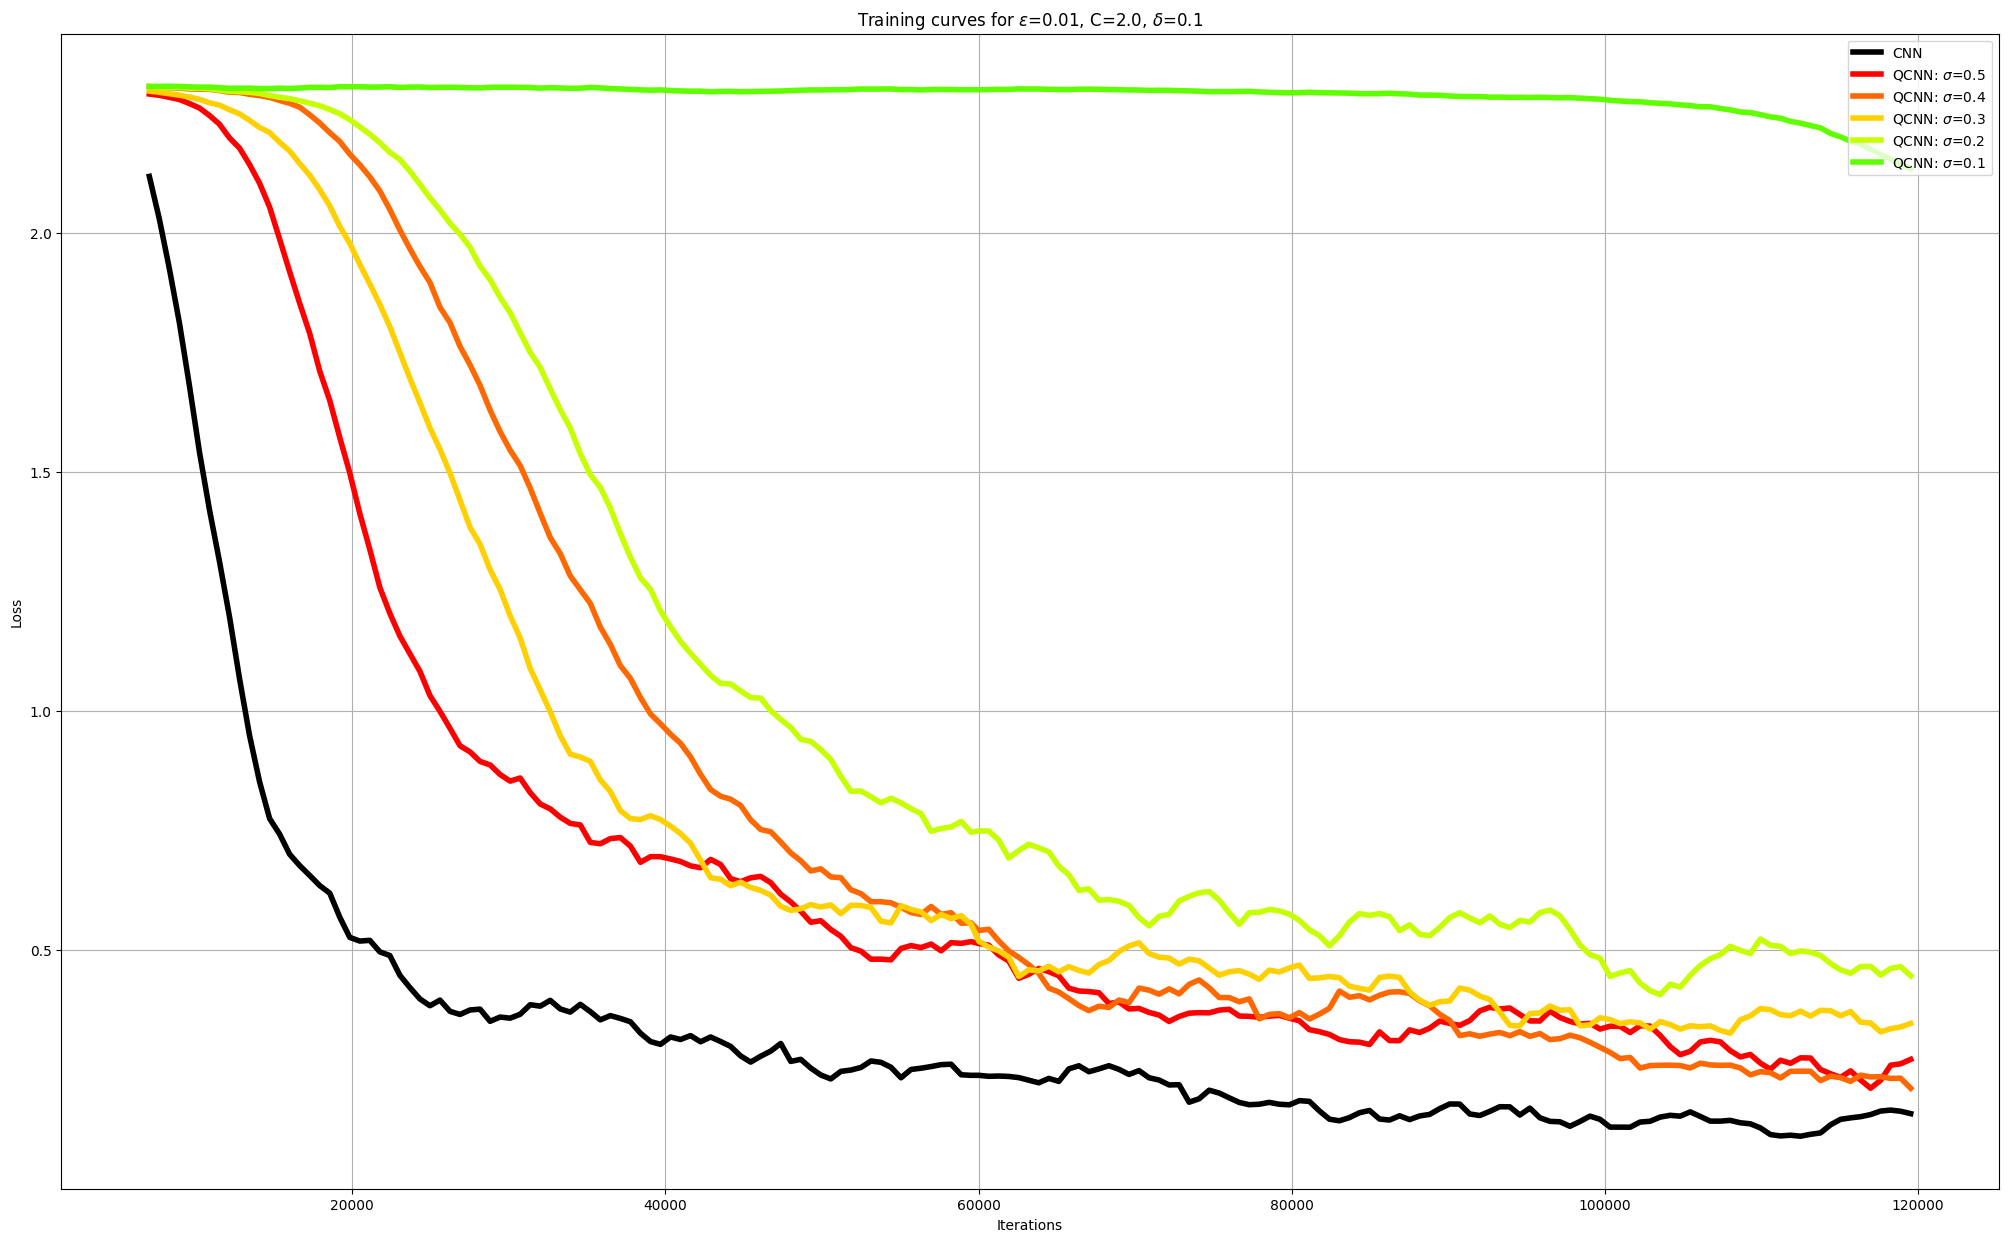

In [80]:
#plot with color

plt.figure(figsize=(25, 15))

plt.plot(all_data['rollmean_CNN'], color='black', label='CNN', linewidth=4)    
for count, name in enumerate(name_list):
    label_split=name.split('_')
    ratio = float((label_split[1].split('-'))[1])
    epsilon = float((label_split[2].split('-'))[1])
    cap = float((label_split[3].split('-'))[1])
    BackprErr = float((label_split[5]))
    label = label_split[0]+': $\sigma$='+str(ratio)#+', $\epsilon$='+str(epsilon)+', cap='+str(cap)+', BackprErr='+str(BackprErr)
    
    color = plt.cm.get_cmap('hsv', 30)
    plt.plot(all_data['rollmean_'+name], color=color(2*count), label=label, linewidth=4)
    
    plt.legend(loc='upper right')
    plt.title('Training curves for $\epsilon$={}, C={}, $\delta$={}'.format(epsilon,cap,BackprErr))
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.grid()
    

fname = 'training_epsilon{}_T{}_delta{}'.format(epsilon,int(cap),BackprErr)
plt.show(block=False)

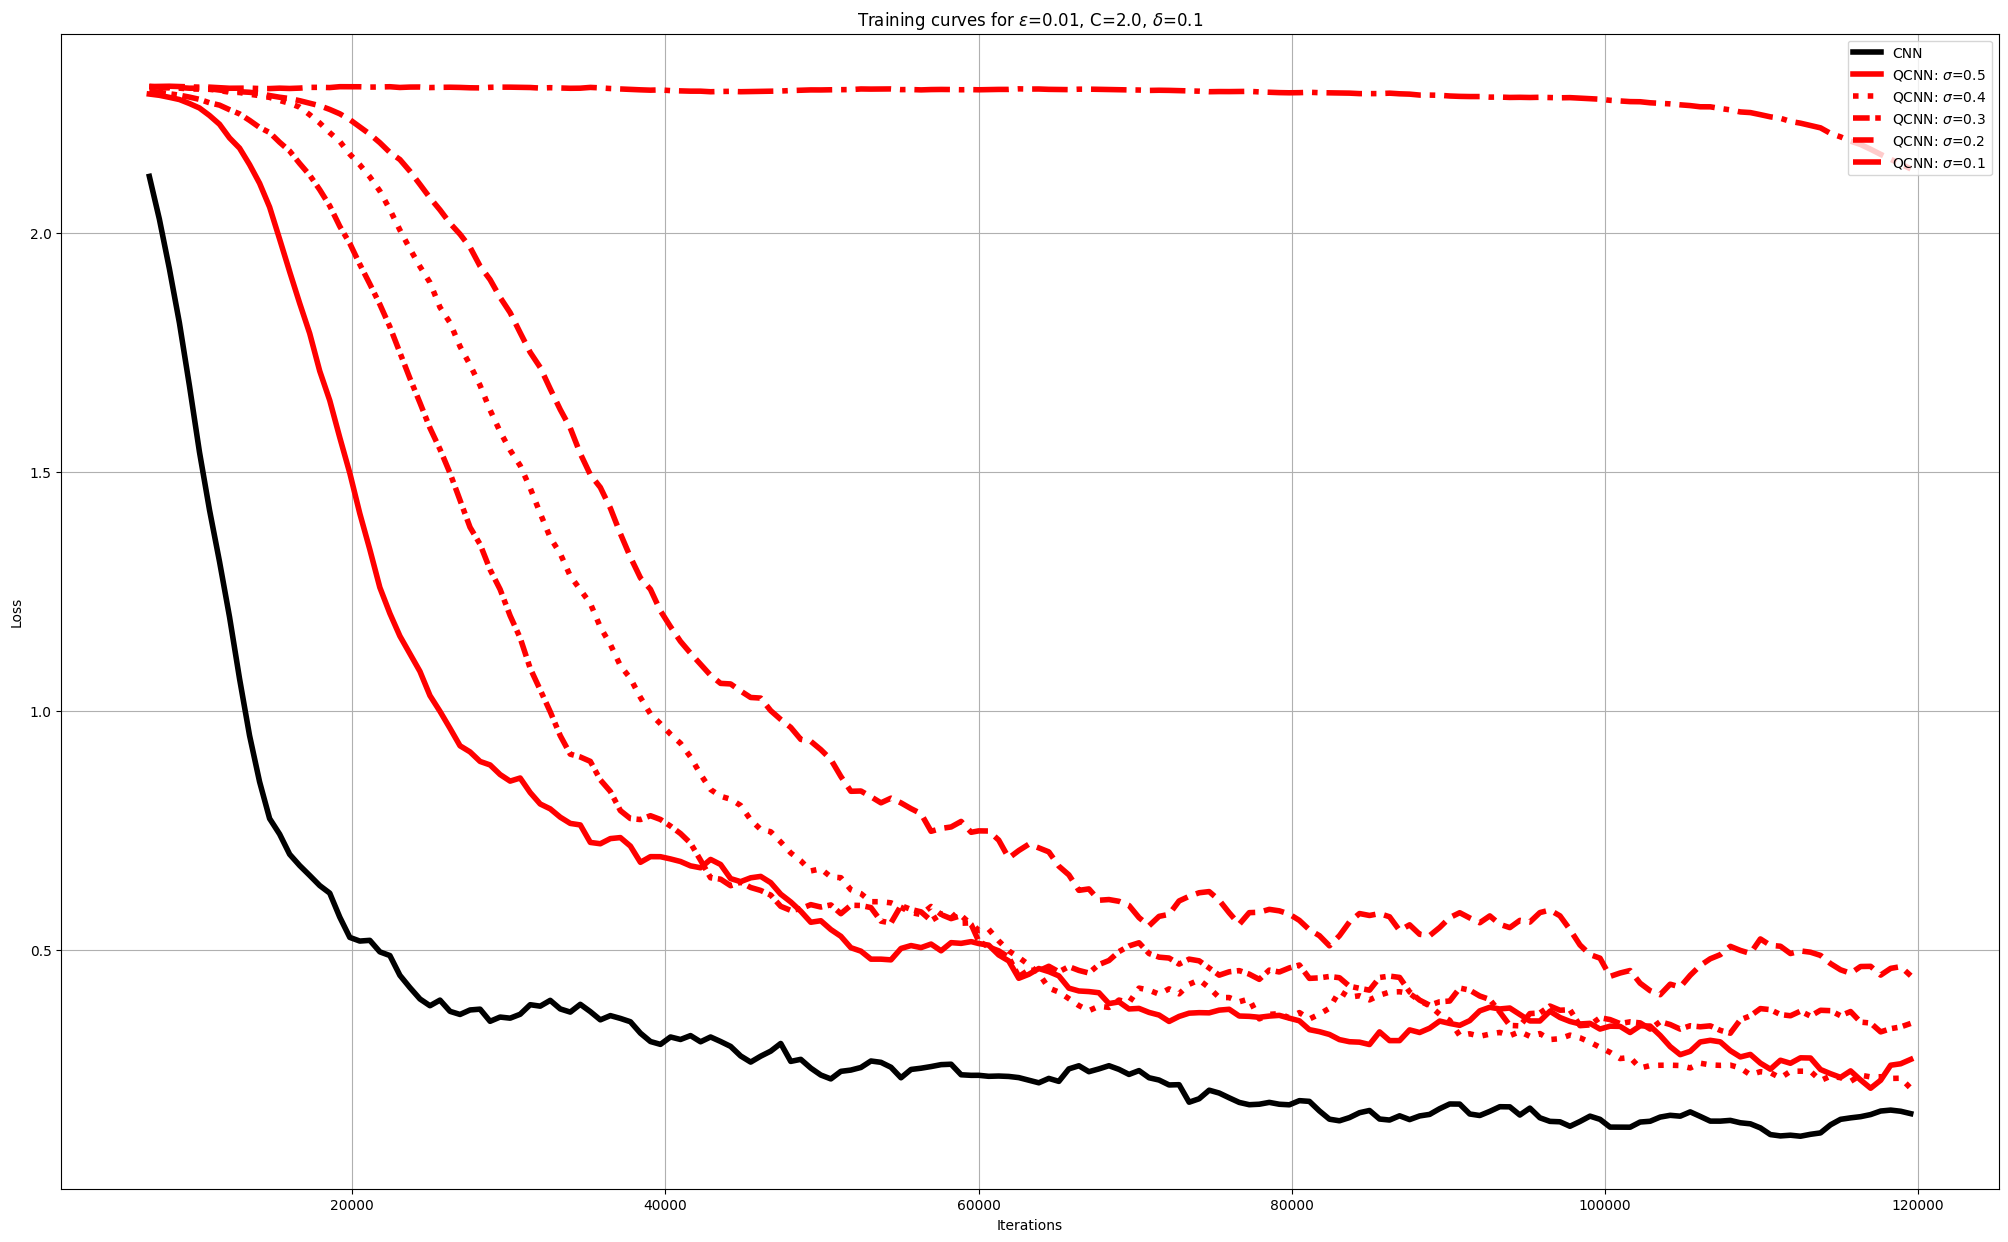

In [81]:
#plot without color  

plt.figure(figsize=(25, 15))

plt.plot(all_data['rollmean_CNN'], color='black', label='CNN', linewidth=4)
for count, name in enumerate(name_list):
    label_split=name.split('_')
    ratio = float((label_split[1].split('-'))[1])
    epsilon = float((label_split[2].split('-'))[1])
    cap = float((label_split[3].split('-'))[1])
    BackprErr = float((label_split[5]))
    label = label_split[0]+': $\sigma$='+str(ratio)#+', $\epsilon$='+str(epsilon)+', cap='+str(cap)+', BackprErr='+str(BackprErr)
    
    LINESTYLE = ["-",":",(0, (3, 1, 1, 1)),"--",'-.']
    plt.plot(all_data['rollmean_'+name], color='red', label=label, linewidth=4, linestyle=LINESTYLE[count%len(LINESTYLE)]) #color=color(count)
    
    plt.legend(loc='upper right')
    plt.title('Training curves for $\epsilon$={}, C={}, $\delta$={}'.format(epsilon,cap,BackprErr))
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.grid()
  
    
fname = 'training_epsilon{}_T{}_delta{}_unicolor'.format(epsilon,int(cap),BackprErr)
plt.show(block=False)

### Test set loss & accuracy


##### quantumly trained QCNN - testset loss & accuracy

In [ ]:
BackpErr_RANGE = [0.01, 0.1]
epsilon_RANGE = [0.01, 0.1]
Cap_RANGE = [10,2]
ratio_RANGE = [0.5]#, 0.4, 0.3, 0.2, 0.1]

In [82]:
result = []

for ratio in ratio_RANGE:
    for Cap in Cap_RANGE:
        for epsilon in epsilon_RANGE:
            for BackpErr in BackpErr_RANGE:

                name = 'QCNN_ratio-'+str(ratio)+'_epsilon-'+str(epsilon)+'_Cap-'+str(Cap)+'_BackpErr_'+str(BackpErr)
                if os.path.isfile((path+'model_'+name+'.pth')):                  


                    net = QCNN(Cap, epsilon, ratio)
                    #load network state
                    network_state_dict = torch.load(path+'model_'+name+'.pth') ##### HERE WE CHOOSE Q-CNN
                    net.load_state_dict(network_state_dict)

                    print('\n\t ***** network:', name,'*****')

                    test(testloader_mnist, net)
                    
                    ## No trainset as it would be too long....

C:\Users\Pragy\AppData\Local\Temp\ipykernel_17076\3785782344.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  network_state_dict = torch.load(path+'model_'+name+'.pth') 


	 ***** network: QCNN_ratio-0.5_epsilon-0.01_Cap-2_BackpErr_0.1 *****


C:\Users\Pragy\AppData\Local\Temp\ipykernel_17076\2972483935.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc3(x))



Test set: Avg. loss: 0.2371, Accuracy: 9281/10000 (92.81%)


	 ***** network: QCNN_ratio-0.4_epsilon-0.01_Cap-2_BackpErr_0.1 *****

Test set: Avg. loss: 0.2346, Accuracy: 9264/10000 (92.64%)


	 ***** network: QCNN_ratio-0.3_epsilon-0.01_Cap-2_BackpErr_0.1 *****

Test set: Avg. loss: 0.3257, Accuracy: 9003/10000 (90.03%)


	 ***** network: QCNN_ratio-0.2_epsilon-0.01_Cap-2_BackpErr_0.1 *****

Test set: Avg. loss: 0.3950, Accuracy: 8759/10000 (87.59%)


	 ***** network: QCNN_ratio-0.1_epsilon-0.01_Cap-2_BackpErr_0.1 *****

Test set: Avg. loss: 2.0507, Accuracy: 4460/10000 (44.60%)



##### classically trained QCNN - testset loss & accuracy

In [83]:
BackpErr_RANGE = [0.1]
epsilon_RANGE = [0.01, 0.1]
Cap_RANGE = [10]
ratio_RANGE = [0.5]#, 0.4, 0.3, 0.2, 0.1]

In [84]:
result = []

for ratio in ratio_RANGE:
    for Cap in Cap_RANGE:
        for epsilon in epsilon_RANGE:
            for BackpErr in BackpErr_RANGE:

                name = 'QCNN_ratio-'+str(ratio)+'_epsilon-'+str(epsilon)+'_Cap-'+str(Cap)+'_BackpErr_'+str(BackpErr)
                if os.path.isfile((path+'model_'+name+'.pth')):                

                    net = QCNN(Cap, epsilon, ratio)
                    #load network state
                    network_state_dict = torch.load(path+'model_CNN.pth') ##### HERE WE CHOOSE CNN
                    net.load_state_dict(network_state_dict)

                    print('\n\t ***** network:', name,'*****')

                    test(testloader_mnist, net)
                    
                    ## No trainset it would be too long....

C:\Users\Pragy\AppData\Local\Temp\ipykernel_17076\3027332134.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  network_state_dict = torch.load(path+'model_CNN.pth') #####


	 ***** network: QCNN_ratio-0.5_epsilon-0.01_Cap-10_BackpErr_0.1 *****


C:\Users\Pragy\AppData\Local\Temp\ipykernel_17076\2972483935.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc3(x))



Test set: Avg. loss: 0.2090, Accuracy: 9417/10000 (94.17%)


	 ***** network: QCNN_ratio-0.5_epsilon-0.1_Cap-10_BackpErr_0.1 *****

Test set: Avg. loss: 0.3202, Accuracy: 9250/10000 (92.50%)

